# Plot prediction and ground truth

In [38]:
import numpy as np
import pandas as pd
import respiration.utils as utils

signals_dir = utils.dir_path('outputs', 'signals')

ground_truth_file = utils.join_paths(signals_dir, 'respiration_gt.csv')
ground_truth = pd.read_csv(ground_truth_file)
ground_truth['signal'] = ground_truth['signal'].apply(eval).apply(np.array)

predictions_file = utils.join_paths(signals_dir, 'raft_predictions.csv')
predictions = pd.read_csv(predictions_file)
predictions['signal_uv'] = predictions['signal_uv'].apply(eval).apply(np.array)
predictions['signal_uv_std'] = predictions['signal_uv_std'].apply(eval).apply(np.array)
predictions['signal_v'] = predictions['signal_v'].apply(eval).apply(np.array)
predictions['signal_v_std'] = predictions['signal_v_std'].apply(eval).apply(np.array)
predictions.head()

,subject,setting,model,roi,sampling_rate,signal_uv,signal_uv_std,signal_v,signal_v_std
0,Proband01,101_natural_lighting,raft_large,full,30,"[0.09339491277933121, 0.1025390774011612, 0.10...","[0.08170297741889954, 0.07249844819307327, 0.0...","[-0.026017149910330772, -0.04469139128923416, ...","[0.09531001001596451, 0.07902514934539795, 0.1..."
1,Proband01,101_natural_lighting,raft_large,chest,30,"[0.07913867384195328, 0.09910967200994492, 0.0...","[0.024328986182808876, 0.0206962488591671, 0.0...","[-0.046315472573041916, -0.08250490576028824, ...","[0.019030965864658356, 0.016680561006069183, 0..."
2,Proband01,101_natural_lighting,raft_large,person,30,"[0.05635499581694603, 0.07663340121507645, 0.0...","[0.0305393785238266, 0.04057435691356659, 0.02...","[-0.008971789851784706, -0.05770755186676979, ...","[0.04073411598801613, 0.04638036713004112, 0.0..."
3,Proband01,101_natural_lighting,raft_small,full,30,"[0.17002850770950317, 0.17359229922294617, 0.1...","[0.13345079123973846, 0.11626102775335312, 0.1...","[-0.014883547089993954, 0.033577051013708115, ...","[0.13700933754444122, 0.14599855244159698, 0.1..."
4,Proband01,101_natural_lighting,raft_small,chest,30,"[0.09740127623081207, 0.06048618629574776, 0.1...","[0.04936320707201958, 0.03215919807553291, 0.0...","[-0.031725313514471054, -0.021138720214366913,...","[0.04351649060845375, 0.025875376537442207, 0...."


In [39]:
subject = 'Proband05'

prediction = predictions[
    (predictions['model'] == 'raft_large') &
    (predictions['roi'] == 'chest') &
    (predictions['subject'] == subject)
    ]

gt_signal = ground_truth[
    (ground_truth['subject'] == subject) &
    (ground_truth['setting'] == '101_natural_lighting')
    ]['signal'].values[0]

gt_signal = gt_signal[1:]

signal_v = prediction['signal_v'].values[0]
sampling_rate = prediction['sampling_rate'].values[0]

gt_signal.shape, signal_v.shape

((3599,), (3599,))

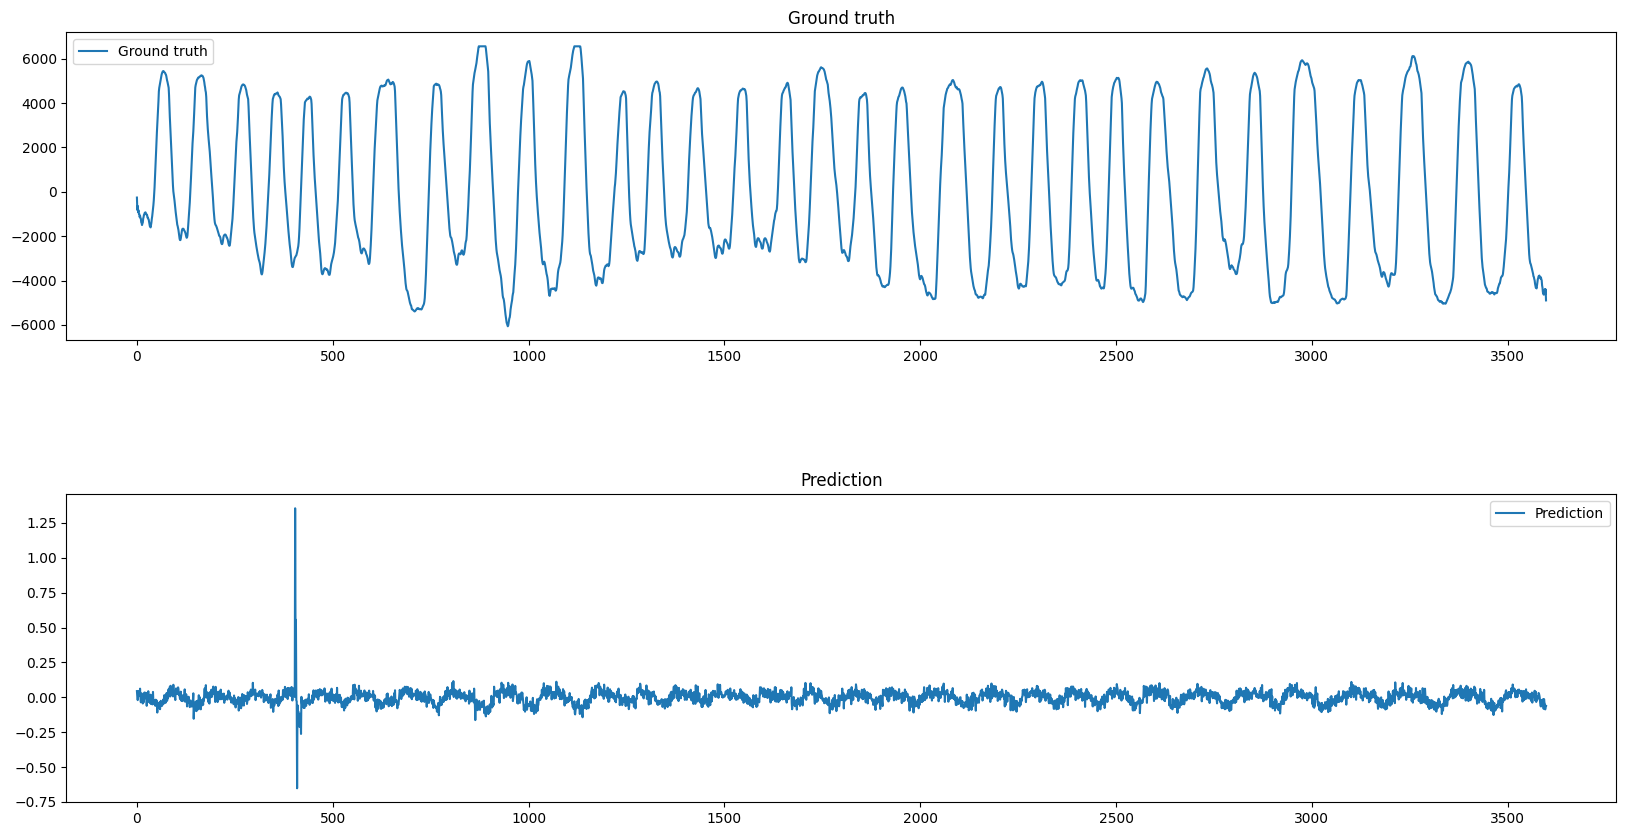

In [45]:
import matplotlib.pyplot as plt

# Plot the raw signals in two separate figures
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# Add some space between the two figures
plt.subplots_adjust(hspace=0.5)

axs[0].plot(gt_signal, label='Ground truth')
axs[0].set_title('Ground truth')
axs[0].legend()

axs[1].plot(signal_v, label='Prediction')
axs[1].set_title('Prediction')
axs[1].legend()

In [41]:
import respiration.analysis as analysis

compare = analysis.SignalComparator(signal_v, gt_signal, sampling_rate)
compare.all_results()

{'pk': {'ground_truth': 30.0, 'prediction': 30.0},
 'cp': {'ground_truth': 30.0, 'prediction': 31.0},
 'nfcp': {'ground_truth': 31.0, 'prediction': 33.0},
 'psd': {'ground_truth': 17.0, 'prediction': 30.0}}

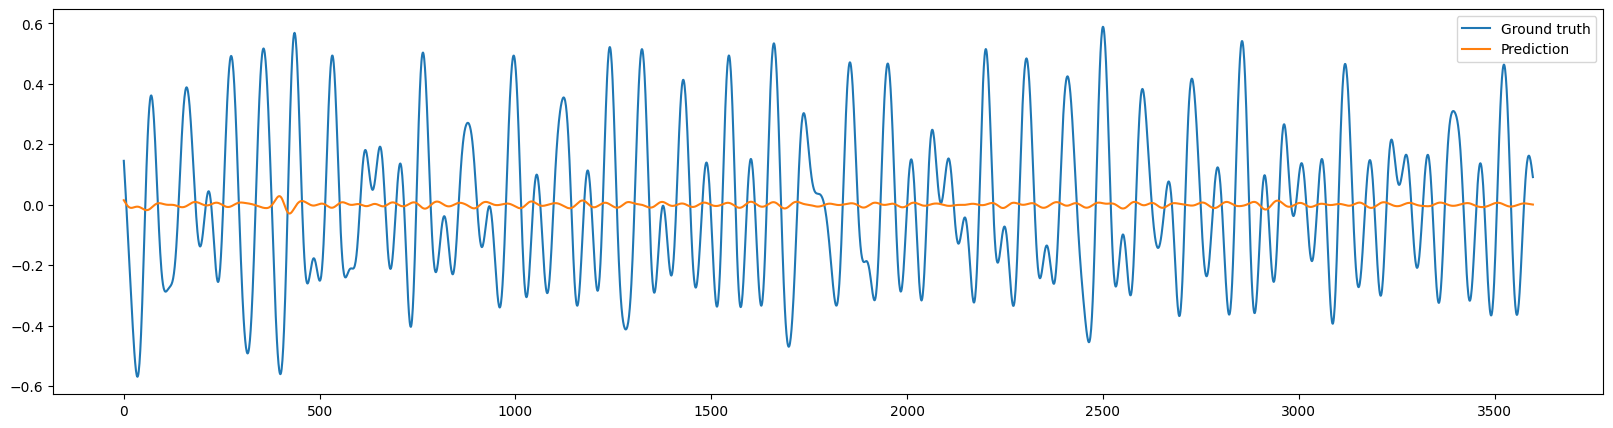

In [42]:
plt.figure(figsize=(20, 5))
plt.plot(compare.ground_truth, label='Ground truth')
plt.plot(compare.prediction, label='Prediction')
plt.legend()
plt.show()